# MNIST
Handwritten digits between 0-9

# DCGAN
Deep Convolutional Genrative Adversarial Networks
https://arxiv.org/pdf/1511.06434.pdf

# PyTorch
Deep Learning Framework

In [1]:
import torch
import torch.nn as nn

# Model

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return  nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g*16, 4,1,0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2,
                channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N,1,1,1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1,1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

In [6]:
test()

Success


In [7]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

In [10]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], 
            [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [11]:
dataset = datasets.MNIST(root="mnist/", train=True, transform=transforms, download=True)

In [12]:
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

In [13]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

In [14]:
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [15]:
initialize_weights(gen)
initialize_weights(disc)

In [16]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))

In [17]:
criterion = nn.BCELoss()

In [18]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [19]:
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0


In [20]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [21]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
        
        ## train disc
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        ## train gen
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # print losses occasionally
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx} / {len(loader)} \
            Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")
            
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
                
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                
            step += 1
                
        

Epoch [0/5] Batch 0 / 469             Loss D: 0.6914, loss G: 0.7790
Epoch [0/5] Batch 100 / 469             Loss D: 0.0147, loss G: 4.1335
Epoch [0/5] Batch 200 / 469             Loss D: 0.6612, loss G: 0.8388
Epoch [0/5] Batch 300 / 469             Loss D: 0.6079, loss G: 1.1176
Epoch [0/5] Batch 400 / 469             Loss D: 0.5812, loss G: 1.1918
Epoch [1/5] Batch 0 / 469             Loss D: 0.6338, loss G: 0.9775
Epoch [1/5] Batch 100 / 469             Loss D: 0.6251, loss G: 0.6589
Epoch [1/5] Batch 200 / 469             Loss D: 0.8080, loss G: 0.4166
Epoch [1/5] Batch 300 / 469             Loss D: 0.5946, loss G: 0.9154
Epoch [1/5] Batch 400 / 469             Loss D: 0.6444, loss G: 0.8355
Epoch [2/5] Batch 0 / 469             Loss D: 0.7032, loss G: 1.2036
Epoch [2/5] Batch 100 / 469             Loss D: 0.6130, loss G: 0.8255
Epoch [2/5] Batch 200 / 469             Loss D: 0.6064, loss G: 0.5080
Epoch [2/5] Batch 300 / 469             Loss D: 0.6186, loss G: 1.6599
Epoch [2/5] 

In [22]:
from IPython.display import Image

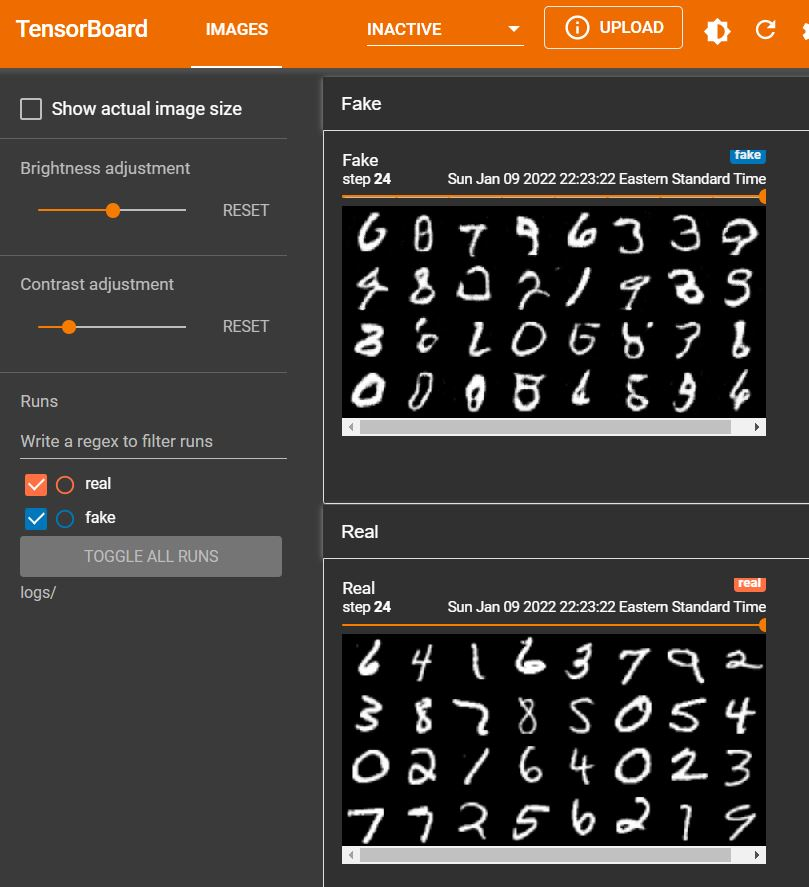

In [24]:
Image(filename='mnist_dcgan_tensorboard.JPG')